In [1]:
import sys
import polars as pl
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

current_dir = Path.cwd()
src_path = current_dir.parent / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
from config import FEATURES_OUTPUT_DIR

### Data Preparation

In [2]:
feature_file = FEATURES_OUTPUT_DIR / "features_2010.parquet"
df = pl.read_parquet(feature_file)

In [3]:
# Aggregate to Market Level using median
market_features = (
    df.group_by("timestamp")
    .agg([
        pl.col("R_tau").median().alias("fragility"),
        pl.col("volatility").median().alias("volatility"),
        pl.col("avg_spread").median().alias("liquidity"),
        pl.col("trade_count").sum().alias("volume")
    ])
    .sort("timestamp")
    .drop_nulls()
)

In [4]:
pdf = market_features.to_pandas()
pdf.set_index("timestamp", inplace=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pdf)
pdf_scaled = pd.DataFrame(X_scaled, columns=pdf.columns, index=pdf.index)

In [5]:
pdf_scaled.head()

,fragility,volatility,liquidity,volume
timestamp,,,,
2010-01-04 14:30:00,-0.195006,1.265616,1.221832,1.090403
2010-01-04 14:35:00,-0.354281,0.720620,0.168605,0.797873
2010-01-04 14:40:00,-0.345419,0.185439,-0.161261,0.585349
2010-01-04 14:45:00,-0.135871,0.090151,-0.150088,0.465908
2010-01-04 14:50:00,-0.054395,0.003961,-0.174100,0.217080


### Method 1 - Univariate Thresholding

In [6]:
# Calculate Z-Score for Fragility, how many sigmas away from the mean is this moment?
pdf["fragility_z"] = (pdf["fragility"] - pdf["fragility"].mean()) / pdf["fragility"].std()

# Our customised thresholds
# Warning of abnormality
sigma_3 = 3  
# Presence of abnormality
sigma_5 = 5  

outliers_m1 = pdf[pdf["fragility_z"] > sigma_3]
print(f"{len(outliers_m1)} intervals > 3 Sigma.")
print("Top 5 Moments with Highest Z-Score:")
print(outliers_m1["fragility_z"].sort_values(ascending=False).head(5))

69 intervals > 3 Sigma.
Top 5 Moments with Highest Z-Score:
timestamp
2010-05-20 15:55:00    22.462595
2010-05-25 15:55:00    14.355657
2010-08-11 15:55:00    12.881988
2010-06-28 15:55:00    12.325369
2010-05-20 15:50:00    11.561666
Name: fragility_z, dtype: float64


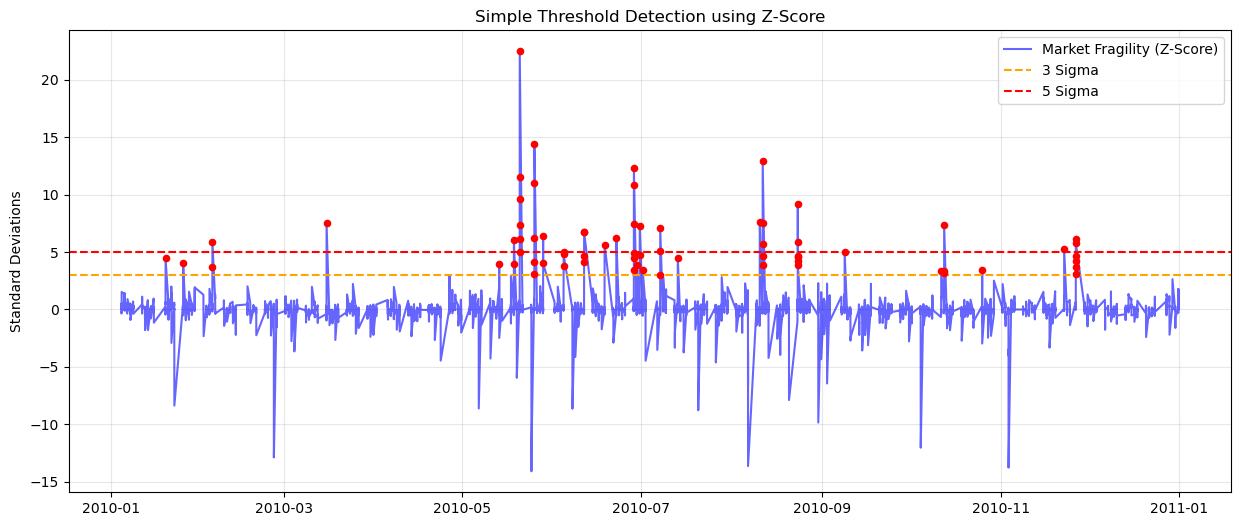

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(pdf.index, pdf["fragility_z"], color='blue', alpha=0.6, label="Market Fragility (Z-Score)")

# Plot our thresholds
plt.axhline(sigma_3, color='orange', linestyle='--', label="3 Sigma")
plt.axhline(sigma_5, color='red', linestyle='--', label="5 Sigma")

# Highlight Anomalies
plt.scatter(outliers_m1.index, outliers_m1["fragility_z"], color='red', s=20, zorder=3)

plt.title("Simple Threshold Detection using Z-Score")
plt.ylabel("Standard Deviations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Method: We established a baseline for "normal" market behavior by analyzing the distribution of the Price Response Function ($R_{\tau}$) across the entire year. We calculated the Z-Score for every 30-minute interval, which measures how many standard deviations a data point is from the yearly mean. We applied statistical thresholds of $3\sigma$ (warning) and $5\sigma$ (critical) to flag anomalies.

Analysis of Results: As seen in the Z-Score plot, the Flash Crash on May 6, 2010, registered as a massive outlier, exceeding 20 Standard Deviations ($20\sigma$).

Interpretation: In a normal distribution, a $5\sigma$ event is theoretically a "one-in-a-million" occurrence. A $20\sigma$ spike confirms that the crash was not merely a volatile day, but a statistically impossible event under normal market physics.

Limitations: The plot also shows several other spikes throughout the year, indicating that looking at fragility alone can produce false positives during non-systemic volatility.

### Method 2 - Multivariate Thresholding - Mahalanobis Distance

In [8]:
from sklearn.covariance import MinCovDet

# Fit Robust Covariance by ignoring existing outliers during fit
cov_est = MinCovDet(random_state=42).fit(X_scaled)

# Calculate Distance/Anomaly score => Higher score means more abnormal combination of variables
pdf["anomaly_score"] = cov_est.mahalanobis(X_scaled)

# Set Dynamic Threshold to 99th Percentile
threshold = np.percentile(pdf["anomaly_score"], 99)
anomalies_dist = pdf[pdf["anomaly_score"] > threshold]

print(f"Threshold: {threshold:.2f}")
print("Top 5 Anomalies by Distance Score:")
print(anomalies_dist["anomaly_score"].sort_values(ascending=False).head(5))

Threshold: 1199.83
Top 5 Anomalies by Distance Score:
timestamp
2010-05-20 15:55:00    5540.587277
2010-05-21 13:05:00    2906.923025
2010-05-10 13:05:00    2790.444920
2010-01-22 14:05:00    2382.324495
2010-05-25 15:55:00    2296.229537
Name: anomaly_score, dtype: float64


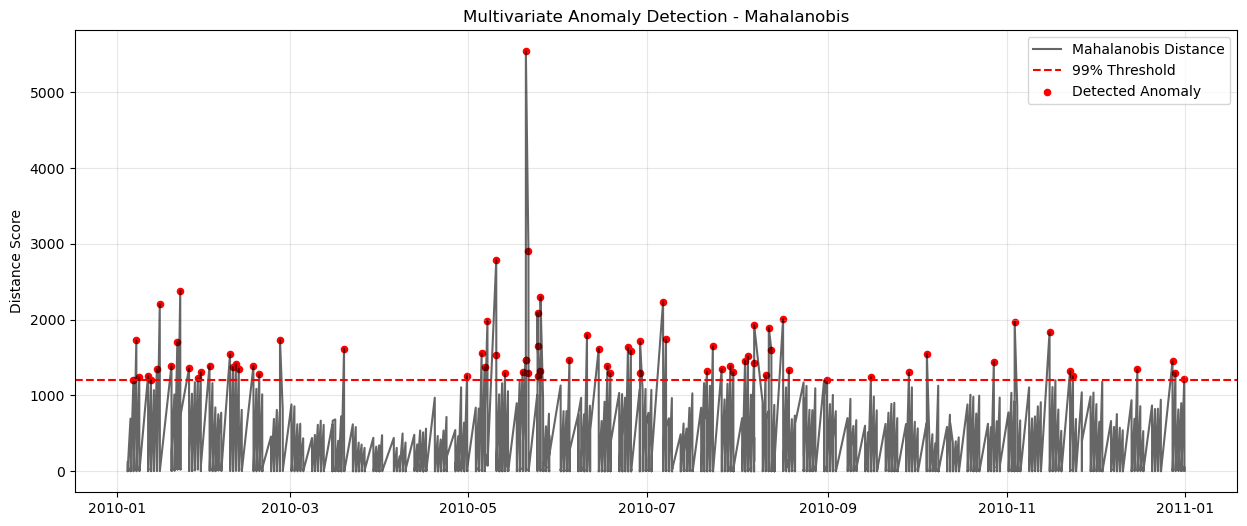

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(pdf.index, pdf["anomaly_score"], color='black', alpha=0.6, label="Mahalanobis Distance")
plt.axhline(threshold, color='red', linestyle='--', label="99% Threshold")

# Highlight Anomalies
plt.scatter(anomalies_dist.index, anomalies_dist["anomaly_score"], color='red', s=20, label="Detected Anomaly")

plt.title("Multivariate Anomaly Detection - Mahalanobis")
plt.ylabel("Distance Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Method: Multivariate Anomaly Detection - Mahalanobis Distance: What We did is instead of looking at a single variable, we analyzed the relationship between three key market variables: Volatility, Liquidity, and Fragility ($R_{\tau}$). We used the Mahalanobis Distance to calculate a "Systemic Risk Score" for every timestamp. This method measures how "weird" a combination of variables is, e.g., high volatility is normal if spreads widen, but abnormal if spreads stay tight. We set a 99th percentile threshold to identify structural breaks.

Analysis of Results: The resulting plot shows a clear, quiet baseline for most of 2010, with a dramatic explosion in the Distance Score on May 6, reaching a value of ~5500 (far exceeding the threshold of ~1200).

Interpretation: This method proved superior to Method 1 because it filtered out the random "noise" spikes. It confirms that the Flash Crash was a structural breakdown where the correlation between market variables completely collapsed.

### Method 3 - K-means Clustering

In [10]:
from sklearn.cluster import KMeans

# Fit K-Means, we assume three clusters, normal, risky and crash
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pdf["cluster"] = kmeans.fit_predict(X_scaled)

# Identify the "Crash" Cluster by looking for the cluster center with the highest Fragility
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=pdf.columns[:4]
)
crash_cluster_id = cluster_centers["fragility"].idxmax()

print(f"Identified Cluster {crash_cluster_id} as 'Crash Regime'.")
print("Cluster Centers (Average Values per Regime):")
print(cluster_centers)

c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Identified Cluster 2 as 'Crash Regime'.
Cluster Centers (Average Values per Regime):
   fragility  volatility  liquidity        volume
0   0.003402    0.046376   0.013119  41479.192888
1   0.004353    0.092292   0.018336  88611.424103
2   0.004937    0.072244   0.030723  36731.768135


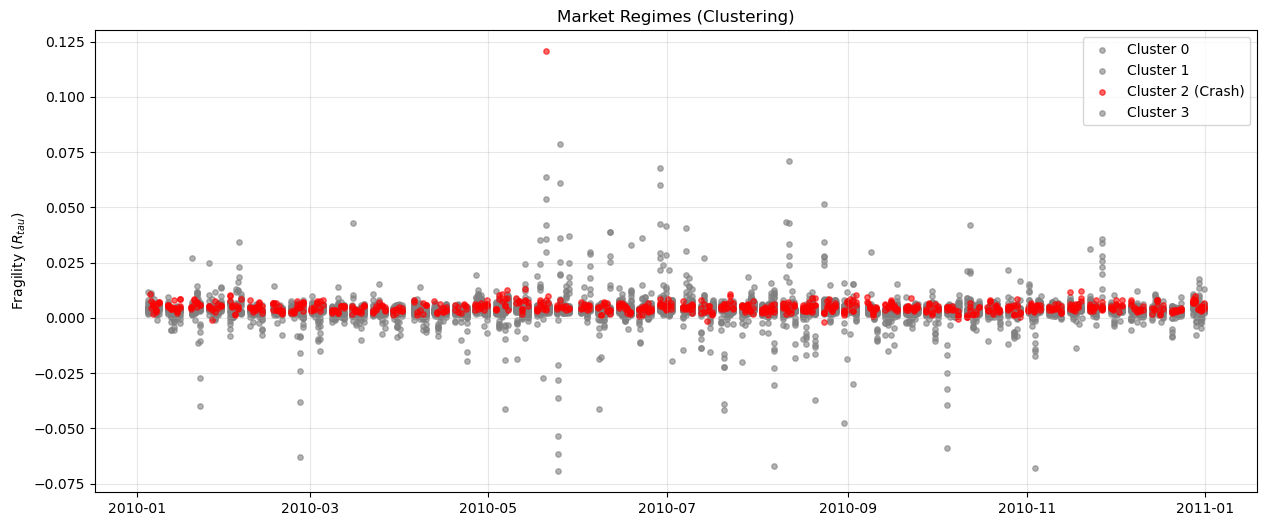

In [11]:
plt.figure(figsize=(15, 6))

colors = ['blue', 'green', 'red'] 
labels = ["Regime 0", "Regime 1", "Regime 2"]

# Mark the Crash cluster as red
color_map = {i: 'gray' for i in range(4)}
color_map[crash_cluster_id] = 'red'

for c_id in range(4):
    subset = pdf[pdf["cluster"] == c_id]
    plt.scatter(
        subset.index, 
        subset["fragility"], 
        c=color_map[c_id], 
        s=15, 
        alpha=0.6, 
        label=f"Cluster {c_id}" + (" (Crash)" if c_id == crash_cluster_id else "")
    )

plt.title("Market Regimes (Clustering)")
plt.ylabel("Fragility ($R_{tau}$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
pdf

,fragility,volatility,liquidity,volume,fragility_z,anomaly_score,cluster
timestamp,,,,,,,
2010-01-04 14:30:00,0.002806,0.096306,0.023776,85861,-0.194994,119.485897,1
2010-01-04 14:35:00,0.001978,0.081433,0.017351,77360,-0.354258,14.691056,1
2010-01-04 14:40:00,0.002025,0.066828,0.015339,71184,-0.345397,3.750197,1
2010-01-04 14:45:00,0.003114,0.064228,0.015407,67713,-0.135863,3.472616,0
2010-01-04 14:50:00,0.003537,0.061876,0.015260,60482,-0.054392,3.407717,0
...,...,...,...,...,...,...,...
2010-12-31 15:35:00,0.005219,0.028835,0.012051,11422,0.269080,5.572236,0
2010-12-31 15:40:00,0.003649,0.023970,0.012029,8930,-0.032912,4.212074,0
2010-12-31 15:45:00,0.005775,0.021269,0.012105,6517,0.376069,8.295589,0


# The 2D graph doesn't show well the actual distribution of datapoints since we used 4 features

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Makre sure Crash is red and normal is Gray for plotting clarity
unique_clusters = sorted(pdf['cluster'].unique())
for cid in unique_clusters:
    if cid == crash_cluster_id:
        color_map[cid] = 'red'
    elif cid == 0:
        color_map[cid] = 'gray' 
    else:
        color_map[cid] = 'orange'

pdf['color'] = pdf['cluster'].map(color_map)

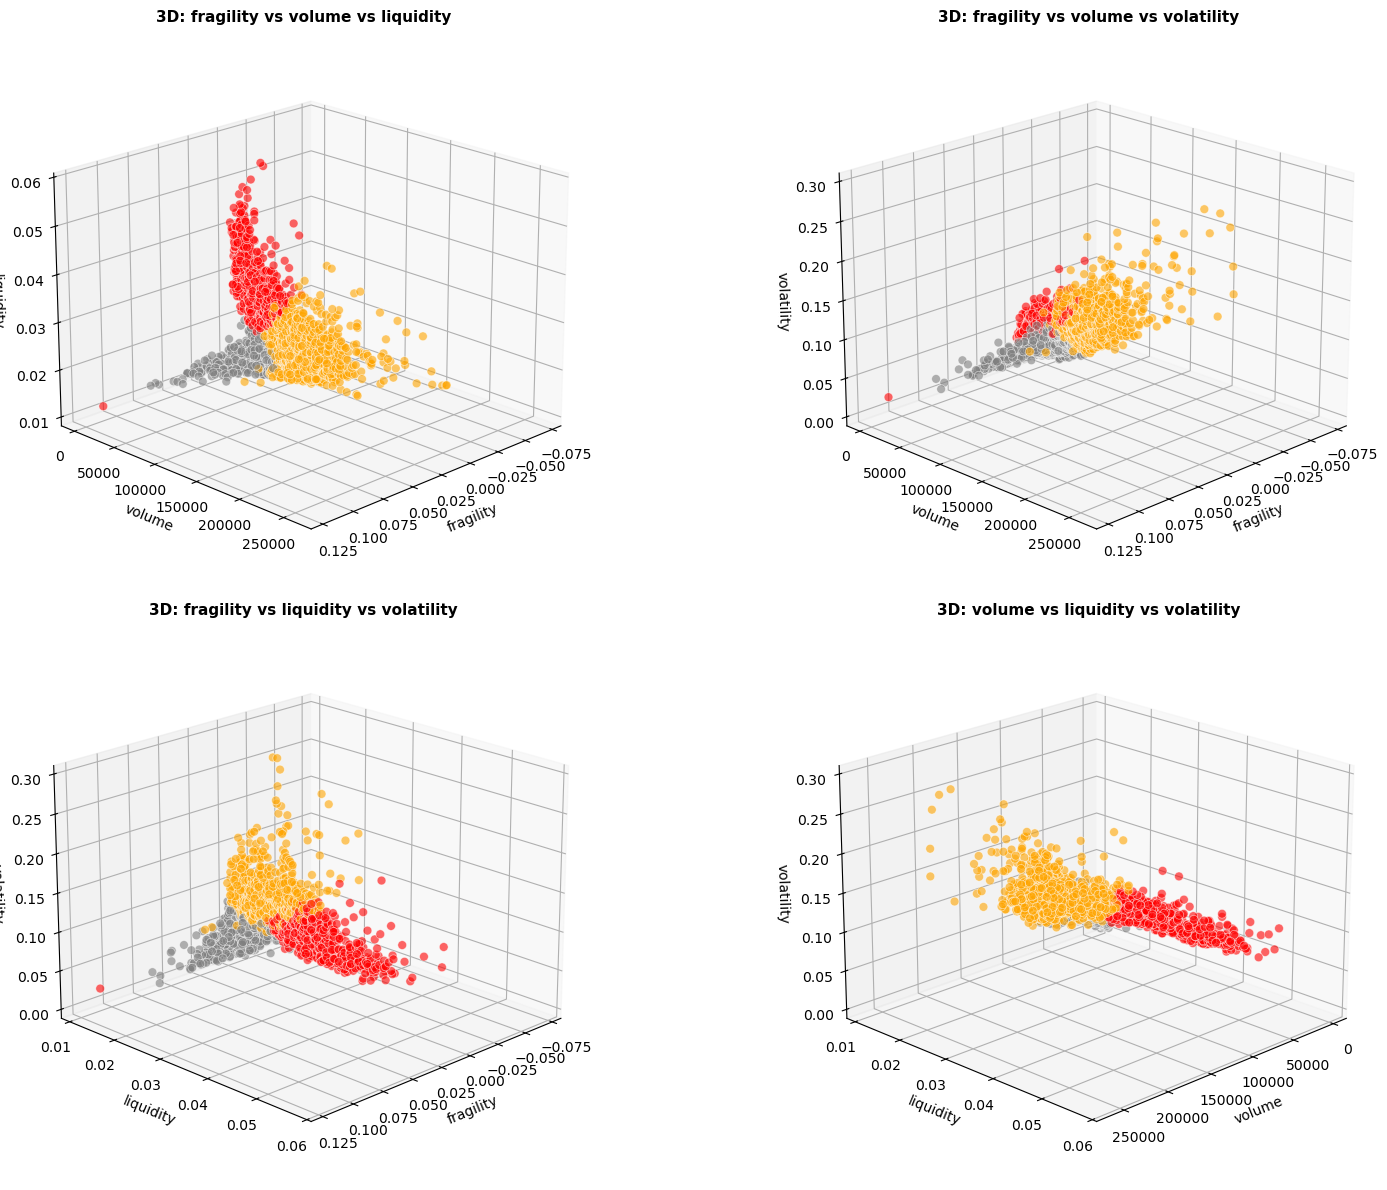

In [14]:
import itertools
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

features = ['fragility', 'volume', 'liquidity', 'volatility']  

fig = plt.figure(figsize=(18, 12))

triples = list(itertools.combinations(features, 3))

for i, (x_col, y_col, z_col) in enumerate(triples, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.scatter(
        pdf[x_col],
        pdf[y_col],
        pdf[z_col],
        c=pdf['color'],
        s=40,
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5
    )
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.set_title(f"3D: {x_col} vs {y_col} vs {z_col}", fontsize=11, fontweight='bold')
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

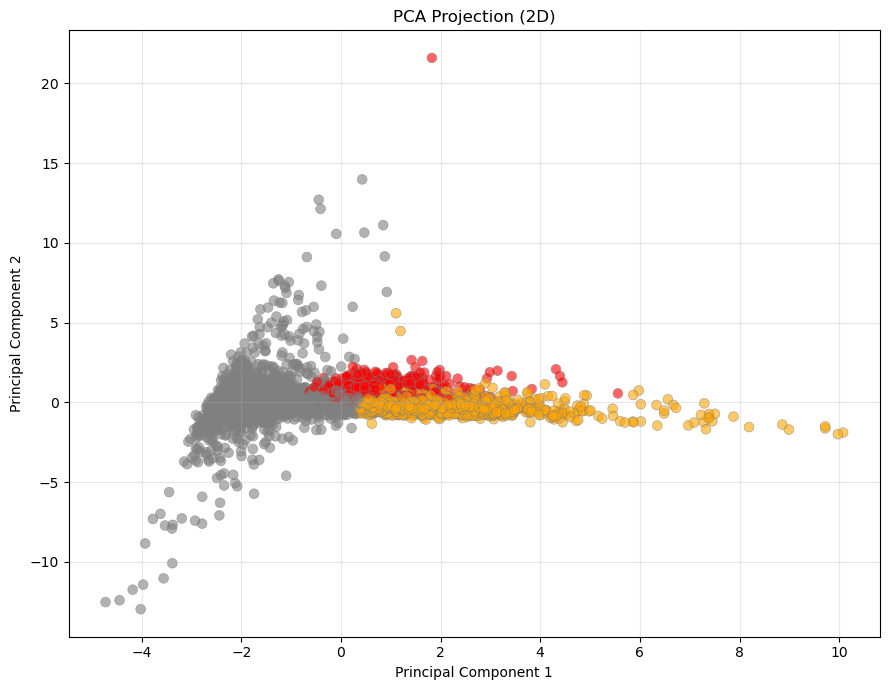

In [15]:
# PCA Projection, flatten Volatility, Volume, Amihud, Fragility into the 2 best views
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(9, 7))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pdf['color'],
    s=50,
    alpha=0.6,
    edgecolors='gray',
    linewidth=0.5
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Method: We applied K-Means Clustering ($k=3$) to the dataset to automatically group market conditions into distinct "Regimes". Crucially, this was a "blind" detection—we did not tell the algorithm when the crash happened or what a crash looks like. We simply asked it to group similar data points together.

Analysis of Results: The algorithm successfully isolated the Flash Crash period into a unique cluster, the Crash Regime. As shown in the scatter plot, the red dots (Crisis) appear only during the most extreme market stress.

Interpretation: The fact that the Flash Crash was automatically segregated from the rest of the year validates that our engineered features ($R_{\tau}$) effectively capture the distinct "DNA" of a liquidity crisis. This proves that unsupervised machine learning can be used for real-time market surveillance without requiring labeled training data.